# Ultrametric benchmark for continual learning - MNIST - Data analysis
#### Simon Lebastard - 01/27/2020

In [1]:
import os

project_root = '/home/proprietaire/Documents/Workspace/Jobs/Columbia/ultrametric_benchmark/Ultrametric-benchmark'

In [2]:
os.chdir(project_root)
import result_loader

In [3]:
simu_type = '1toM'

dataset = 'MNIST_10'
nnarchi = 'CNN'
seq_length = 200000
n_batches = 10
seq_genr_type = 'temporal_correlation'
lr=0.05

# Foar artificial ultrametric dataset only
linear_ratio_for_artificial_seq = 8
artificial_seq_len = 200

In [4]:
import ast

with open('Results/simu_mapping_dict.txt', 'r', encoding='utf-8') as filenames:
    filenames_dct_txt = filenames.read().replace('\n', '')
    
datapaths = ast.literal_eval(filenames_dct_txt)

In this notebook, we'll loop through the files produced by the ultrametric framework accross temperatures and shuffle block size, and construct dictionnaries indexed by [T, blocksz].
We will then use those dicts to create the plots for DARPA.

Now let's load standard packages and find out about the content of each file:

In [5]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import pdb

import pickle
%matplotlib inline

In [6]:
os.chdir(project_root+'/Results_Multi')


dataroot = project_root+'/Results/1toM/' + dataset + '/' + nnarchi + '/' + 'temporal_correlation_length' + str(seq_length)+'_batches'+str(n_batches)
if 'artificial' in dataset:
    dataroot += '_seqlen'+str(artificial_seq_len)+'_ratio'+str(linear_ratio_for_artificial_seq)

rs = result_loader.ResultSet_1toM(
    dataroot,
    datapaths['1toM'][dataset][nnarchi]['temporal_correlation'][(0.05, 200000)]
)
rs.load_analytics()

dataroot = project_root+'/Results/1to1/' + dataset + '/' + nnarchi + '/' + 'uniform_length' + str(seq_length)+'_batches'+str(n_batches)
if 'artificial' in dataset:
    dataroot += '_seqlen'+str(artificial_seq_len)

rs_unif = result_loader.ResultSet_1to1(
    dataroot,
    datapaths['1to1'][dataset][nnarchi]['uniform'][(0.05, 200000)]
)
rs_unif.load_analytics(load_shuffle=False)


# dataroot = project_root+'/Results/' + dataset + '/' + nnarchi + '/' + 'twofold_split_length' + str(seq_length)+'_batches'+str(n_batches)
# if 'artificial' in dataset:
#     dataroot += '_seqlen'+str(artificial_seq_len)+'_ratio'+str(linear_ratio_for_artificial_seq)

# rs_tfs = ResultSet(
#     dataroot,
#     datapaths[(dataset, nnarchi, 'twofold_split', 'ratio_'+str(linear_ratio_for_artificial_seq))]
# )
# rs_tfs.load_analytics()

load_data set to False. Data sequences not loaded.
load_atc set to False. Autocorrelations not loaded.
load_data set to False. Data sequences not loaded.
load_atc set to False. Autocorrelations not loaded.


In [7]:
os.chdir(project_root+"/plots")

## Labels history

In [ ]:
rs.lbl_history([0.37])

In [ ]:
rs.lbl_history([0.4])

## Accuracy = f(t) plots

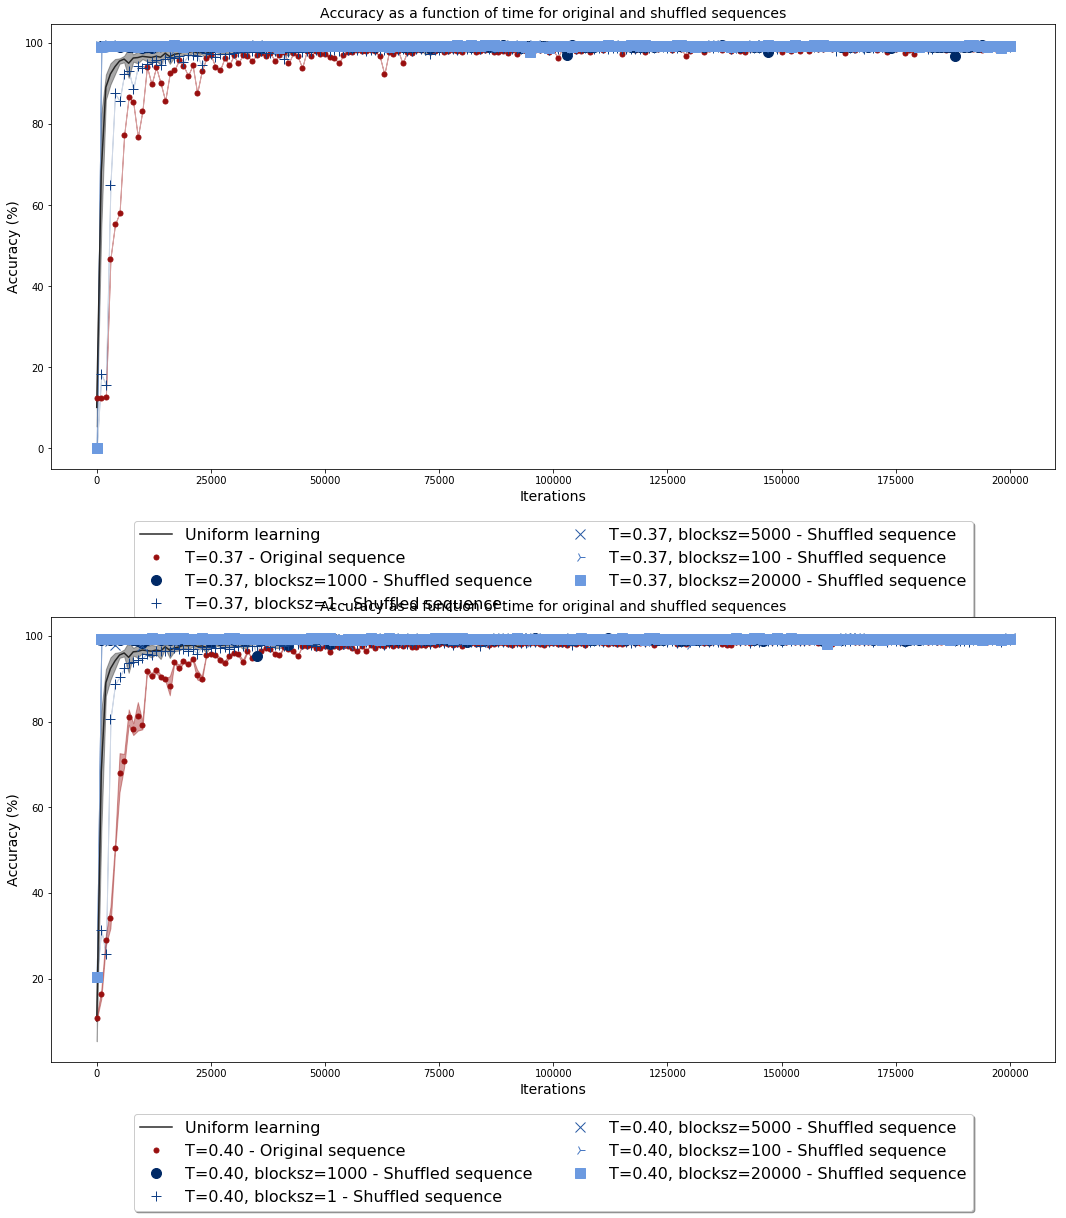

In [8]:
result_loader.get_acc(
    T_list = [0.37, 0.4],
    acc_temp_orig = rs.var_acc_orig,
    acc_temp_shuffled = {
        0.37: {block_sz: rs.var_acc_shfl[0.37][block_sz] for block_sz in rs.block_sizes},
        0.4: {block_sz: rs.var_acc_shfl[0.4][block_sz] for block_sz in rs.block_sizes}
    },
    acc_unif = [v for v in rs_unif.var_acc_orig.values()][0]
)

## Autocorrelation plots (computed a posteriori)

Let's plot the autocorrelation function to DARPA standards:

In [ ]:
rs.get_atc(
    T_list=[0.4],
    n_tests=10,
    out_filename='atc_artificial32_T04'
)

## Miscelanneous - Previous implementation of visualization units

In [ ]:
from copy import deepcopy
import random
from scipy.spatial.distance import cdist
import time
from matplotlib.colors import hsv_to_rgb
from tqdm.notebook import tqdm

def shuffleblocks(seq, block_sz, snbr):
    lseq = len(seq)
    copied_seq = deepcopy(seq)
    sseq = []   # Will contain the shuffled sequence
    for k in range(snbr):
        begin, end = int(k*lseq/snbr), int((k+1)*lseq/snbr)
        bbegin, bend = int(begin/block_sz), int(end/block_sz)
        block_indices = [i for i in range(len(seq[:end])//block_sz)]
        random.shuffle(block_indices)
        for i in block_indices[bbegin:bend]:
            sseq += copied_seq[i*block_sz:(i+1)*block_sz]
    return sseq 

def get_atc_forloop(seq_list, blocks, snbr, filename, T, w_size=10000):
    tree_l = max(seq_list[0])+1
    plt.figure(1, figsize=(18,10))
    hlocs_stat_orig = np.zeros(w_size)
    hlocs_stat_shfl = np.zeros(w_size)
    
    hsv_orig = (0, 0.9, 0.6)
    n_omits = 30
    markers = ['o','+','x',',']
    bins_hist = range(w_size)
    
    print("Computing autocorrelation on {0:d} sequences".format(len(seq_list)))
    
    for seq_id, seq in tqdm(enumerate(seq_list), desc='Sequence #'):
        print("   Original sequence {0:d}...".format(seq_id))
        for lbl_id in tqdm(range(tree_l), desc='Leaf #'):
            locs_orig = np.array([j for j in range(len(seq)) if seq[j]==lbl_id])
            nlocs = len(locs_orig)
            locs_orig = locs_orig.reshape((nlocs, 1))
            
            for loc1_id, loc1 in enumerate(locs_orig):
                for loc2 in locs_orig[loc1_id:]:
                    locd = loc2 - loc1
                    if locd < w_size:
                        hlocs_stat_orig[locd,0] += 1

        print("   ...done")

    if hlocs_stat_orig[0] > 0:
        hlocs_stat_orig = hlocs_stat_orig / hlocs_stat_orig[0]
        
    bins_atc = range(w_size//2)
    plt.loglog(
        bins_atc,
        hlocs_stat_orig[::2],
        marker='.',
        color = hsv_to_rgb(hsv_orig),
        ls = 'solid',
        label='T={0:.2f} - Original sequence'.format(T)
    ) 
    
    hlocs_stat_shfl_list = []
    for nfig, block_sz in enumerate(blocks):
        print("   Block size {0:d}".format(block_sz))
        hsv_shfl = tuple([0.6, 1-nfig*0.2, 0.5+nfig*0.15])
        #plt.figure(nfig+2)
        #plt.plot(shuffleseq)
        #plt.title(block_sz)
        for seq_id, seq in enumerate(seq_list):
            shuffleseq = shuffleblocks(seq, block_sz, snbr)
            print("       Shuffled sequence {1:d}...".format(block_sz, seq_id))
            for lbl_id in range(tree_l):
                locs_shfl = np.array([j for j in range(len(shuffleseq)) if  shuffleseq[j]==lbl_id])
                nlocs = len(locs_shfl)
                locs_shfl = locs_shfl.reshape((nlocs, 1))
                locsd_mat_shfl = cdist(locs_shfl, locs_shfl, 'cityblock')     
                iu_ids = np.triu_indices(nlocs)
                bins = range(w_size)
                hlocs_shfl = np.bincount(
                    locsd_mat_shfl[iu_ids].reshape((int(nlocs*(nlocs+1)/2),1))
                )
                # hlocs_shfl = np.histogram(
                #     locsd_mat_shfl[iu_ids].reshape((int(nlocs*(nlocs+1)/2),1)),
                #     bins=w_size,
                #     range=(0, w_size)
                # )
                
                hlocs_stat_shfl = hlocs_stat_shfl + hlocs_shfl[0]/tree_l
            print("       ...done")
        
        if hlocs_stat_shfl[0] > 0:
            hlocs_stat_shfl = hlocs_stat_shfl / hlocs_stat_shfl[0]
        
        plt.figure(1)    
        plt.loglog(
            bins_atc,
            hlocs_stat_shfl[::2],
            marker = markers[nfig],
            ls = 'solid',
            color = hsv_to_rgb(hsv_shfl),
            label='T={0:.2f} - Shuffled with blocksz={1:d}'.format(T, block_sz),
            alpha=0.5) 
        hlocs_stat_shfl_list.append(hlocs_stat_shfl)
        
    plt.title('Autocorrelation of training sequence')
    plt.xlabel('t, number of iterations /2', fontsize=12)
    plt.ylabel('A(t)', fontsize=14)
    plt.legend(prop={'size': 16})
    
    plt.savefig(
        fname=filename+'.pdf',
        format='pdf'
    )
        
    return hlocs_stat_orig, hlocs_stat_shfl_list


def get_atc_vectorized(seq_list, blocks, snbr, filename, T, w_size=10000):
    tree_l = max(seq_list[0])+1
    plt.figure(1, figsize=(18,10))
    hlocs_stat_orig = np.zeros(w_size)
    hlocs_stat_shfl = np.zeros(w_size)
    
    hsv_orig = (0, 0.9, 0.6)
    n_omits = 30
    markers = ['o','+','x',',']
    bins_hist = range(w_size)
    
    print("Computing autocorrelation on {0:d} sequences".format(len(seq_list)))
    
    for seq_id, seq in tqdm(enumerate(seq_list), desc='Sequence #'):
        print("   Original sequence {0:d}...".format(seq_id))
        for lbl_id in tqdm(range(tree_l), desc='Leaf #'):
            locs_orig = np.array([j for j in range(len(seq)) if seq[j]==lbl_id])
            nlocs = len(locs_orig)
            locs_orig = locs_orig.reshape((nlocs, 1))
            
            locsd_mat_orig = cdist(locs_orig, locs_orig, 'cityblock')
            #     iu_ids_couples = np.array([(i,j) for j in range(20) for i in range(20*cut_id, 20*cut_id+j)])
            iu_ids = np.triu_indices(nlocs)
            iu_len = len(iu_ids[0])
            diffs = locsd_mat_orig[iu_ids].reshape((iu_len,1))
            hlocs_orig = hlocs_orig + np.histogram(
                diffs,
                bins=w_size,
                range=(0,w_size)
            )
            hlocs_stat_orig = hlocs_stat_orig + hlocs_orig[0]/tree_l

        print("   ...done")


    if hlocs_stat_orig[0] > 0:
        hlocs_stat_orig = hlocs_stat_orig / hlocs_stat_orig[1]
        
    bins_atc = range(w_size//2)
    plt.loglog(
        bins_atc,
        hlocs_stat_orig[::2],
        marker='.',
        color = hsv_to_rgb(hsv_orig),
        ls = 'solid',
        label='T={0:.2f} - Original sequence'.format(T)
    ) 
    
    hlocs_stat_shfl_list = []
    for nfig, block_sz in enumerate(blocks):
        print("   Block size {0:d}".format(block_sz))
        hsv_shfl = tuple([0.6, 1-nfig*0.2, 0.5+nfig*0.15])
        #plt.figure(nfig+2)
        #plt.plot(shuffleseq)
        #plt.title(block_sz)
        for seq_id, seq in enumerate(seq_list):
            shuffleseq = shuffleblocks(seq, block_sz, snbr)
            print("       Shuffled sequence {1:d}...".format(block_sz, seq_id))
            for lbl_id in range(tree_l):
                locs_shfl = np.array([j for j in range(len(shuffleseq)) if  shuffleseq[j]==lbl_id])
                nlocs = len(locs_shfl)
                locs_shfl = locs_shfl.reshape((nlocs, 1))
                locsd_mat_shfl = cdist(locs_shfl, locs_shfl, 'cityblock')     
                iu_ids = np.triu_indices(nlocs)
                bins = range(w_size)
                hlocs_shfl = np.bincount(
                    locsd_mat_shfl[iu_ids].reshape((int(nlocs*(nlocs+1)/2),1))
                )
                # hlocs_shfl = np.histogram(
                #     locsd_mat_shfl[iu_ids].reshape((int(nlocs*(nlocs+1)/2),1)),
                #     bins=w_size,
                #     range=(0, w_size)
                # )
                
                hlocs_stat_shfl = hlocs_stat_shfl + hlocs_shfl[0]/tree_l
            print("       ...done")
        
        if hlocs_stat_shfl[0] > 0:
            hlocs_stat_shfl = hlocs_stat_shfl / hlocs_stat_shfl[0]
        
        plt.figure(1)    
        plt.loglog(
            bins_atc,
            hlocs_stat_shfl[::2],
            marker = markers[nfig],
            ls = 'solid',
            color = hsv_to_rgb(hsv_shfl),
            label='T={0:.2f} - Shuffled with blocksz={1:d}'.format(T, block_sz),
            alpha=0.5) 
        hlocs_stat_shfl_list.append(hlocs_stat_shfl)
        
    plt.title('Autocorrelation of training sequence')
    plt.xlabel('t, number of iterations /2', fontsize=12)
    plt.ylabel('A(t)', fontsize=14)
    plt.legend(prop={'size': 16})
    
    plt.savefig(
        fname=filename+'.pdf',
        format='pdf'
    )
        
    return hlocs_stat_orig, hlocs_stat_shfl_list



def get_atc_matrixcuts(seq_list, blocks, snbr, filename, T, w_size=10000):
    tree_l = max(seq_list[0])+1
    plt.figure(1, figsize=(18,10))
    hlocs_orig = np.zeros((w_size,1))
    hlocs_shfl = np.zeros((w_size,1))
    
    hsv_orig = (0, 0.9, 0.6)
    n_omits = 30
    markers = ['o','+','x',',']
    bins_hist = range(w_size)
    
    print("Computing autocorrelation on {0:d} sequences".format(len(seq_list)))
    
    for seq_id, seq in tqdm(enumerate(seq_list), desc='Sequence #'):
        print("   Original sequence {0:d}...".format(seq_id))
        for lbl_id in tqdm(range(tree_l), desc='Leaf #'):
            locs_orig = np.array([j for j in range(len(seq)) if seq[j]==lbl_id])
            nlocs = len(locs_orig)
            locs_orig = locs_orig.reshape((nlocs, 1))
            
            for cut_id in tqdm(range(nlocs//20 - 1), desc='Split', leave=False):
                locs = locs_orig[cut_id*20:(cut_id+1)*20,:]
                locsd_mat_orig = cdist(locs_orig, locs, 'cityblock')
                iu_ids_couples = np.array([(i,j) for j in range(20) for i in range(20*cut_id, 20*cut_id+j)])
                iu_ids = (iu_ids_couples[:,0], iu_ids_couples[:,1])
                iu_len = len(iu_ids[0])
                diffs = locsd_mat_orig[iu_ids].reshape((iu_len,1))
                hlocs_orig = hlocs_orig + np.histogram(
                    diffs,
                    bins=w_size,
                    range=(0,w_size)
                )

        print("   ...done")

    hlocs_stat_orig = hlocs_orig.tolist()
    if hlocs_stat_orig[1] > 0:
        hlocs_stat_orig = hlocs_stat_orig / hlocs_stat_orig[1]
        
    bins_atc = range(w_size//2)
    plt.loglog(
        bins_atc,
        hlocs_stat_orig[::2],
        marker='.',
        color = hsv_to_rgb(hsv_orig),
        ls = 'solid',
        label='T={0:.2f} - Original sequence'.format(T)
    ) 
    
    hlocs_stat_shfl_list = []
    for nfig, block_sz in enumerate(blocks):
        print("   Block size {0:d}".format(block_sz))
        hsv_shfl = tuple([0.6, 1-nfig*0.2, 0.5+nfig*0.15])
        #plt.figure(nfig+2)
        #plt.plot(shuffleseq)
        #plt.title(block_sz)
        for seq_id, seq in enumerate(seq_list):
            shuffleseq = shuffleblocks(seq, block_sz, snbr)
            print("       Shuffled sequence {1:d}...".format(block_sz, seq_id))
            for lbl_id in range(tree_l):
                locs_shfl = np.array([j for j in range(len(shuffleseq)) if  shuffleseq[j]==lbl_id])
                nlocs = len(locs_shfl)
                locs_shfl = locs_shfl.reshape((nlocs, 1))
                locsd_mat_shfl = cdist(locs_shfl, locs_shfl, 'cityblock')     
                iu_ids = np.triu_indices(nlocs)
                bins = range(w_size)
                hlocs_shfl = np.bincount(
                    locsd_mat_shfl[iu_ids].reshape((int(nlocs*(nlocs+1)/2),1))
                )
                # hlocs_shfl = np.histogram(
                #     locsd_mat_shfl[iu_ids].reshape((int(nlocs*(nlocs+1)/2),1)),
                #     bins=w_size,
                #     range=(0, w_size)
                # )
                
                hlocs_stat_shfl = hlocs_stat_shfl + hlocs_shfl[0]/tree_l
            print("       ...done")
        
        if hlocs_stat_shfl[0] > 0:
            hlocs_stat_shfl = hlocs_stat_shfl / hlocs_stat_shfl[0]
        
        plt.figure(1)    
        plt.loglog(
            bins_atc,
            hlocs_stat_shfl[::2],
            marker = markers[nfig],
            ls = 'solid',
            color = hsv_to_rgb(hsv_shfl),
            label='T={0:.2f} - Shuffled with blocksz={1:d}'.format(T, block_sz),
            alpha=0.5) 
        hlocs_stat_shfl_list.append(hlocs_stat_shfl)
        
    plt.title('Autocorrelation of training sequence')
    plt.xlabel('t, number of iterations /2', fontsize=12)
    plt.ylabel('A(t)', fontsize=14)
    plt.legend(prop={'size': 16})
    
    plt.savefig(
        fname=filename+'.pdf',
        format='pdf'
    )
        
    return hlocs_stat_orig, hlocs_stat_shfl_list

In [ ]:
hlocs_stat_orig, hlocs_stat_shfl_list = get_atc(
    rs.train_labels_orig[(0.4, 10)],
    block_sizes,
    n_tests,
    'atc_artificial32_T04',
    T=0.4
)

In [ ]:
import copy

os.chdir(project_root+'/plots/artificial_32')

plt.figure(1, figsize=(18,10))
hsv_orig = (0, 0.9, 0.6)
markers = ['o','+','x',',']
block_sizes = (1, 10, 100, 1000)

bins_atc = range(w_size//2)
tmp_orig = copy.deepcopy(hlocs_stat_orig)
tmp_orig[1::2] = None

plt.loglog(
    bins_atc,
    hlocs_stat_orig[::2],
    marker='.',
    color = hsv_to_rgb(hsv_orig),
    ls = 'solid',
    label='T={0:.2f} - Original sequence'.format(0.4)
)

for nfig, hlocs_stat_shfl in enumerate(hlocs_stat_shfl_list):
    hsv_shfl = tuple([0.6, 1-nfig*0.2, 0.5+nfig*0.15])
    block_sz = block_sizes[nfig]
    tmp_shfl = copy.deepcopy(hlocs_stat_shfl)
    tmp_shfl[1::2] = None
    plt.loglog(
        bins_atc,
        hlocs_stat_shfl[::2],
        marker = markers[nfig],
        ls = 'solid',
        color = hsv_to_rgb(hsv_shfl),
        label='T={0:.2f} - Shuffled with blocksz={1:d}'.format(0.4, block_sz),
        alpha=0.5)
    
plt.legend(prop={'size': 16})
plt.title('Autocorrelation of training sequence', fontsize=16)
plt.xlabel('t, number of iterations /2', fontsize=14)
plt.ylabel('A(t)', fontsize=14)

plt.savefig(
    fname='atc_artificial32_T04',
    format='pdf'
)

In [ ]:
os.chdir(project_root+'/plots/artificial_32')

plt.figure(1, figsize=(18,10))
hsv_orig = (0, 0.9, 0.6)
markers = ['o','+','x',',']
block_sizes = (1, 10, 100, 1000)

bins_atc = range(w_size//2)
tmp_orig = copy.deepcopy(hlocs_stat_orig)
tmp_orig[1::2] = None

plt.loglog(
    bins_atc,
    hlocs_stat_orig[::2],
    marker='.',
    color = hsv_to_rgb(hsv_orig),
    ls = 'solid',
    label='T={0:.2f} - Original sequence'.format(0.4)
)

for nfig, hlocs_stat_shfl in enumerate(hlocs_stat_shfl_list):
    hsv_shfl = tuple([0.6, 1-nfig*0.2, 0.5+nfig*0.15])
    block_sz = block_sizes[nfig]
    tmp_shfl = copy.deepcopy(hlocs_stat_shfl)
    tmp_shfl[1::2] = None
    plt.loglog(
        bins_atc,
        hlocs_stat_shfl[::2],
        marker = markers[nfig],
        ls = 'solid',
        color = hsv_to_rgb(hsv_shfl),
        label='T={0:.2f} - Shuffled with blocksz={1:d}'.format(0.4, block_sz),
        alpha=0.5)
    
plt.legend(prop={'size': 16})
plt.title('Autocorrelation of training sequence', fontsize=16)
plt.xlabel('t, number of iterations /2', fontsize=14)
plt.ylabel('A(t)', fontsize=14)

plt.savefig(
    fname='atc_artificial32_T04',
    format='pdf'
)

In [ ]:
hlocs_stat_orig_065, hlocs_stat_shfl_list_065 = get_atc(
    rs.train_labels_orig[(0.65, 10)],
    block_sizes,
    n_tests,
    'atc_artificial32_T065'
    T=0.65)

## Distribution of training labels along training sequence

In [ ]:
n_hists = 10
max_time = 50000

acc_fig = plt.figure(figsize=(18,n_hists*9))

for hist_id in range(n_hists):
    acc_ax = plt.subplot(n_hists, 1, 1+hist_id)

    label_hists = {0.4:[], 0.65: []}

    #for params in list(rs.params.keys()):
    for shfl_block_sz in [1, 10, 100, 1000]:
        total_seq_length = len(rs.train_labels_orig[(0.4, shfl_block_sz)][0][:max_time])
        label_hists[0.4].extend([
            np.histogram(
                label_sq[:(hist_id+1)*(total_seq_length//n_hists)],
                range = (0, 32),
                bins = 32
            )[0] for label_sq in rs.train_labels_orig[(0.4, shfl_block_sz)]
        ])
        label_hists[0.65].extend([
            np.histogram(
                label_sq[:(hist_id+1)*(total_seq_length//n_hists)],
                range = (0, 32),
                bins = 32
            )[0] for label_sq in rs.train_labels_orig[(0.65, shfl_block_sz)]
        ])
      
    label_hist_tot = {0.4: [], 0.65: []}
    label_hist_tot[0.4] = (1/np.sum(label_hists[0.4]))*np.sum(label_hists[0.4], axis=0)
    label_hist_tot[0.65] = (1/np.sum(label_hists[0.65]))*np.sum(label_hists[0.65], axis=0)
    
    acc_ax.bar(
        x = [k-0.1 for k in range(0,32)],
        width=0.2,
        height = label_hist_tot[0.4],
        color = 'g',
        alpha = 0.5,
        label = "Distribution of sequence labels for T=0.4, at iteration {0:d}".format((hist_id+1)*(total_seq_length//n_hists))
    )
    acc_ax.bar(
        x = [k+0.1 for k in range(0,32)],
        width=0.2,
        height = label_hist_tot[0.65],
        color = 'b',
        alpha = 0.5,
        label = "Distribution of sequence labels for T=0.65, at iteration {0:d}".format((hist_id+1)*(total_seq_length//n_hists))
    )
    acc_ax.set_ylim(0, 0.4)
        
    acc_ax.legend()
    plt.savefig('out_plots_labels_dstr.png')

## Predicted class distribution as function of test run

In [ ]:
def plot_class_distribution(param_tuple):

    cls_dstr_fig = plt.figure(figsize=(18,18))

    n_tests = int(rs.params[param_tuple][0]['Number of tests'])

    for test_run_q in range(10): #rs.params['test_nbr'] or whatever

        cls_dstr_ax = plt.subplot(5,2,test_run_q+1)
        test_run_id = int((test_run_q/10)*n_tests)
        
        var_pred_orig = np.mean([pred[test_run_id,0] for pred in rs.var_pred_orig[params]], axis=0)
        var_pred_shfl = np.mean([pred[test_run_id,0] for pred in rs.var_pred_shfl[params]], axis=0)
        
        cls_dstr_ax.bar(
            [k - 0.2 for k in range(32)],
            var_pred_orig,
            color = 'b',
            width = 0.3
        )

        cls_dstr_ax.bar(
            [k + 0.2 for k in range(32)],
            var_pred_shfl,
            color = 'r',
            width = 0.3
        )

        n_training_examples_seen = int(((test_run_id+1) / n_tests)*seq_length)
        plt.title('Distribution of predicted classes within test batch after training on {0:d} examples'.format(n_training_examples_seen))

In [ ]:
rs.params[(0.4, 1)][0]

In [ ]:
plot_class_distribution((0.4, 1))

In [ ]:
plot_class_distribution((0.4, 10))

In [ ]:
plot_class_distribution((0.4, 100))

In [ ]:
plot_class_distribution((0.4, 1000))

In [ ]:
plot_class_distribution((0.65, 1))

In [ ]:
plot_class_distribution((0.65, 10))

In [ ]:
plot_class_distribution((0.65, 100))

In [ ]:
plot_class_distribution((0.65, 1000))